# TA Analysis: Improve PSF Centering

In high-contrast imaging, pinpointing the star's location hidden behind the coronographic mask is essential for accurate point spread function (PSF) subtraction. Currently, SpaceKLIP addresses this challenge by simulating the star's PSF behind the coronagraph using WebbPSF. This simulated PSF is then cross-correlated with the observed PSF, and the cross-correlation peak reveals the star's offset relative to the mask center. 

Here, we introduce a new method for determining the star's location behind the coronagraphic mask by incorporating Target Acquisition (TA) data. TA is a precise procedure that measures the centroid of a source and accurately positions it within a predefined aperture or subarray. Using this centroid information, we can adjust the target's World Coordinate System (WCS) to reflect a more accurate estimate of its position relative to the coronagraphic mask. This method should improve the PSF centering and simplify the alignment process for NIRCam and MIRI data.

This notebook describes how the new toggle in `calculate_centers` function—part of SpaceKLIP's `ImageTools` class—leverages TA data to compute and apply the necessary offsets to the target coordinates. This notebook can be run on NIRCam or MIRI data with TA images. 

## Table of Contents
* [1. Imports](#1.-Imports)
* [2. Query for TA Image(s)](#2.-Query-for-TA-Image(s))
* [3. Plot TA Image(s)](#3.-Plot-TA-Image(s))
* [4. TA Centroid Measurements](#4.-TA-Centroid-Measurements)
    * [4.1 Query OSS Log](#4.1-Query-OSS-Log)
    * [4.2 Plot OSS Centroid](#4.2-Plot-OSS-Centroid)
* [5. TA World Coordinate System](#5.-TA-World-Coordinate-System)
    * [5.1 Plot Target Coordinates from WCS](#5.1-Plot-Target-Coordinates-from-WCS)
* [6. Calculate OSS/WCS Offset](#6.-Calculate-OSS/WCS-Offset)
* [7. Conclusion](#7.-Conclusion)

---

## 1. Imports

In [4]:
# General imports.
import numpy as np
import matplotlib.pyplot as plt

# Astropy: for FITS file handling, units, etc.
import astropy
import astropy.units as u
from astropy.io import fits

# JWST modules: for working with JWST data models and adjusting WCS information.
import jwst.datamodels as datamodels
from jwst.tweakreg.utils import adjust_wcs

# SpaceKLIP modules.
import spaceKLIP.engdb as engdb
import spaceKLIP.target_acq_tools as target_acq_tools
import spaceKLIP.utils as utils

---
## 2. Query for TA Image(s)

To locate the associated TA images for a given observation, we must provide `get_visit_ta_image` with a visit ID and the instrument's name. Here we use a calibrated Stage 2 products from the NIRCam and MIRI tutorial demo data and extract the required information from the header.


In [5]:
cal_product = './data_nircam_hd65426/stage2/jw01386001001_0310e_00001_nrcalong_calints.fits' # NIRCam
# cal_product = './data_miri_hd65426/stage2/jw01386007001_04101_00001_mirimage_calints.fits' # MIRI

In [6]:
visitid = 'V'+fits.getval(cal_product, 'VISIT_ID')
instrument = fits.getval(cal_product, 'INSTRUME')

In [7]:
# Images are saved in memory not to disk.
ta_images = target_acq_tools.get_visit_ta_image(visitid, inst=instrument)

[spaceKLIP.target_acq_tools:INFO] --> Querying MAST for target acquisition files (visit V01386001001)
[spaceKLIP.target_acq_tools:INFO] --> Found 1 target acquisition image(s).
[spaceKLIP.target_acq_tools:INFO] --> TA file: jw01386001001_02102_00001_nrcalong_cal.fits


---

## 3. Plot TA Image(s)


Some observations have multiple TA images. We display the first one by default.

In [8]:
# If there are multiple TA images define what TA image to plot.
num_ta = sum(isinstance(hdu, fits.PrimaryHDU) for hdu in ta_images)
ta_expnum = num_ta - 1 # Use last TA image by default; usually has centroid info.


Call `show_ta_img` with the visit ID and instrument name to display the TA image. This function lets you choose which TA image to display when multiple are available, and it also offers an option to mark the Science Instrument Aperture File (SIAF) reference point—which indicates the intended target position within that aperture's field of view.

Optionally, `show_ta_img` returns handles that we use later to add additional details to the TA image plot.


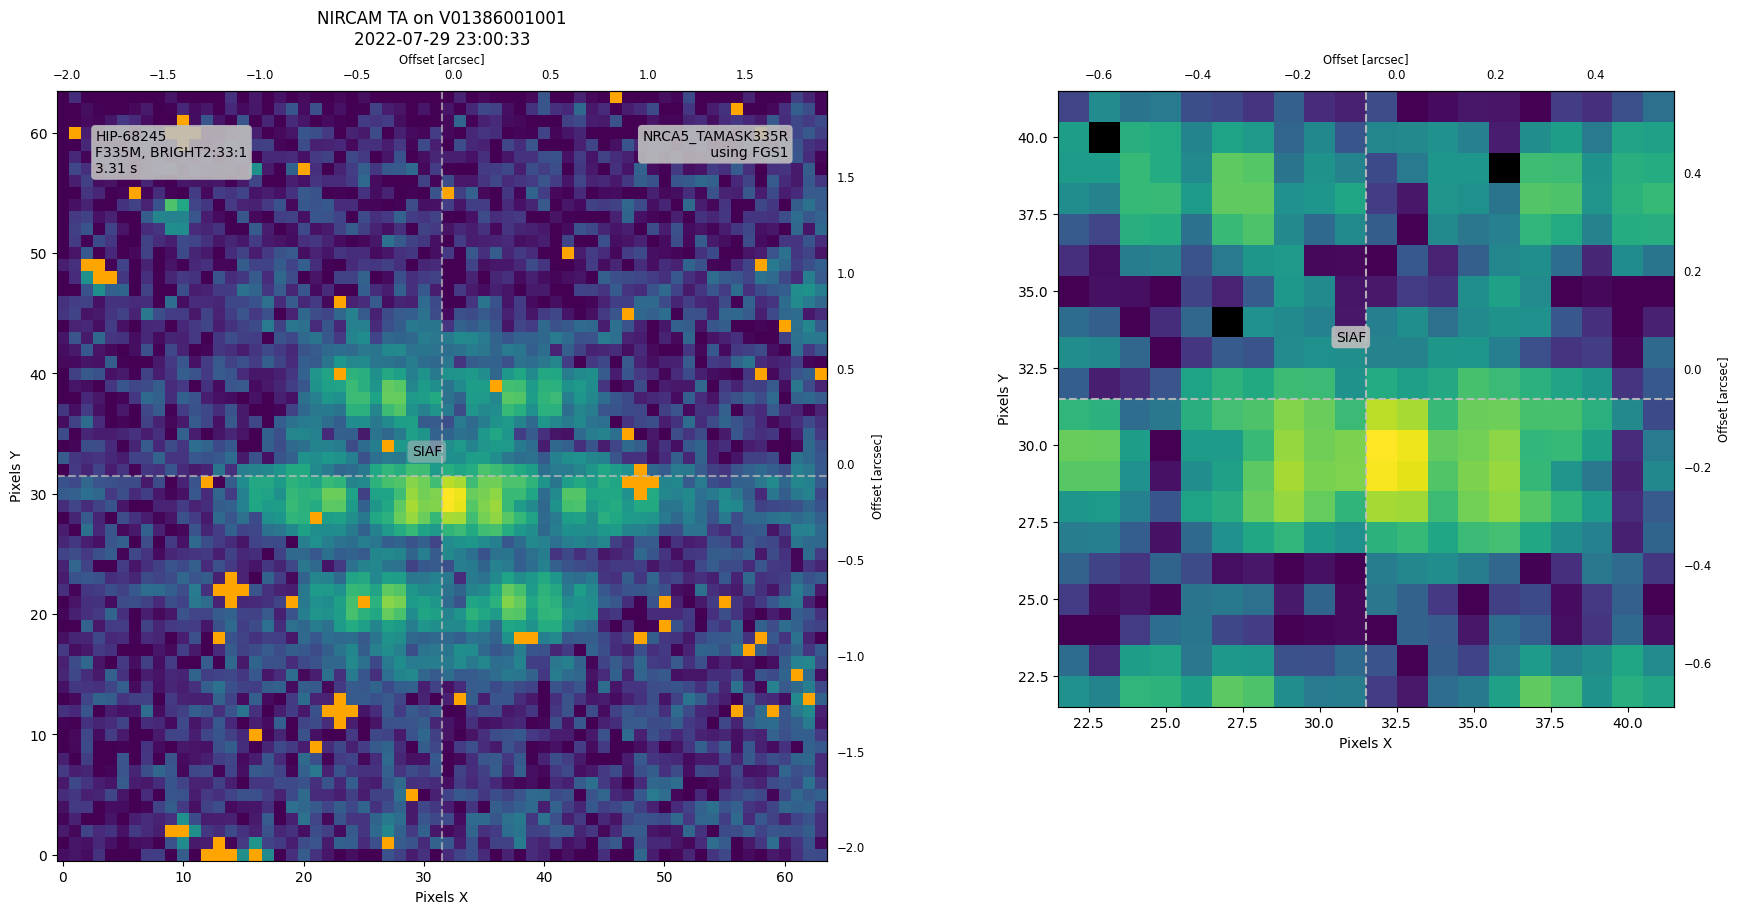

In [9]:
# Plot the TA image(s).
(ta_image_hdul,
 ax, norm,
 cmap, bglevel,
 inset_axes) = target_acq_tools.show_ta_img(visitid,
                                            inst=instrument,
                                            return_handles=True,
                                            ta_expnum=ta_expnum,  # if multiple images.
                                            mark_reference_point=True,
                                            mark_apername=True,
                                            zoom=20)  # zoom width around SIAF center.

In the plot above, the SIAF reference point—indicated by the gray hash lines—is obtained using the `get_siaf` function in `utils.py`. Here's how it works:

In [10]:
# Retrieve the TA aperture and reference point.
siaf = utils.get_siaf(instrument)
ta_aperture = siaf.apertures[ta_image_hdul[0].header['APERNAME']]
# This should match the label in the plots above.
print(f"The TA aperture is {ta_aperture.AperName}")

# Extract reference coordinates.
xref, yref = ta_aperture.XSciRef - 1, ta_aperture.YSciRef - 1  # 0-indexed
print (f"Intended Target Position (from SIAF) = {xref, yref} pix")

The TA aperture is NRCA5_TAMASK335R
Intended Target Position (from SIAF) = (31.5, 31.5) pix


---

## 4. TA Centroid Measurements

The centroid calculated during TA is performed in real-time onboard the spacecraft and is recorded in the Onboard Science Software (OSS) log. This information is not included in the science data products, so to access the centroid data, we must retrieve the corresponding OSS log. <br><br>


### 4.1 Query OSS Log 

We use the `get_ictm_event_log` function in `engdb.py` to retrieve the OSS log for this visit. This function queries the engineering database for an event log that falls within the time range of the TA observation. The start and end times of the TA are extracted from the FITS header (VSTSTART and VISITEND) and passed as arguments. 


In [11]:
ta_start = ta_image_hdul[0].header['VSTSTART']
ta_end = ta_image_hdul[0].header['VISITEND']

osslog = engdb.get_ictm_event_log(ta_start, ta_end)
osslog  # Returns a table of lines from the log.

Time,MJD,Message
str26,float64,str80
2022-07-29 22:01:47.391000,59789.9179096181,VISIT V01176241001 ENDED
2022-07-29 22:01:51.487000,59789.9179570255,VISIT V01386001001 STARTED
2022-07-29 22:02:00.703000,59789.9180636921,Script activated: V01386001001:CONVST
2022-07-29 22:02:02.751000,59789.9180873958,Script terminated: V01386001001:CONVST:Proceed
2022-07-29 22:02:04.799000,59789.9181110995,Group V01386001001:01 started
2022-07-29 22:02:05.823000,59789.9181229514,Seq V01386001001:P00000000:01:1 started
2022-07-29 22:02:07.871000,59789.9181466551,Script activated: V01386001001P0000000001101:SCSLEWMAIN
2022-07-29 22:06:39.231000,59789.9212873958,Observation Plan will stop after V01759005001
2022-07-29 22:06:47.423000,59789.9213822106,Script terminated: OPE_REQUEST_STOP_AFTER_VST:OPREQUEST:Proceed


The OSS log contains much information, some of which isn't directly related to TA. To filter through the log and extract only the TA-related centroid data, we use `extract_oss_TA_centroids` in `engdb.py`. If multiple TA images exist, the function returns centroid information for each—unless NIRCam performed dithered TAs, in which case a centroid is only recorded at the final position.

**Note**: The OSS measures centroids in full-frame coordinates (2048 x 2048).  

In [12]:
oss_cen = engdb.extract_oss_TA_centroids(osslog, visitid)

# Determine centroid if multiple TAs.
oss_cen = oss_cen[ta_expnum - 1] if ta_expnum else oss_cen[0]
print(f"OSS centroid(s) on board (x, y) [pix]:  "
      f"{oss_cen}  (full det coord frame, 1-based)")

OSS centroid(s) on board (x, y) [pix]:  (1557.8437, 1548.52431)  (full det coord frame, 1-based)


Let's convert from full-frame (as used by OSS) to the TA detector subarray coordinates:


In [13]:
# For MIRI only, deal with the fact that the image data
# can be full array even if the aperture is subarray.
if instrument == 'MIRI':
    subarray = ta_image_hdul[0].header['SUBARRAY']
    full_ap = siaf["MIRIM_FULL"]
    if subarray == 'FULL':
        aperture = full_ap
    elif subarray == 'SLITLESSPRISM':
        # Special case: pointed wusing TASLITLESSPRISM but SLITLESSPRISM readout.
        aperture = siaf['MIRIM_SLITLESSPRISM']
    elif subarray.startswith('MASK'):
        aperture = siaf['MIRIM_' + subarray]
    else:
        aperture = ta_aperture
else:
    aperture = ta_aperture

# Convert the centroid from detector to TA subarray coordinates.
oss_cen_sci = np.asarray(aperture.det_to_sci(*oss_cen))
# Convert from 1-based pixel indexing to 0-based.
oss_cen_sci_pythonic = oss_cen_sci - 1
print(f"OSS centroid converted (x, y) [pix]: {oss_cen_sci_pythonic}  "
      f"(sci frame in {aperture.AperName}, 0-based)")

OSS centroid converted (x, y) [pix]: [32.1563  29.52431]  (sci frame in NRCA5_TAMASK335R, 0-based)



### 4.2 Plot OSS Centroid 

Now that we have converted the OSS centroid to the TA coordinate system (and adjusted it to 0-based indexing), we can overlay this point onto our TA image.


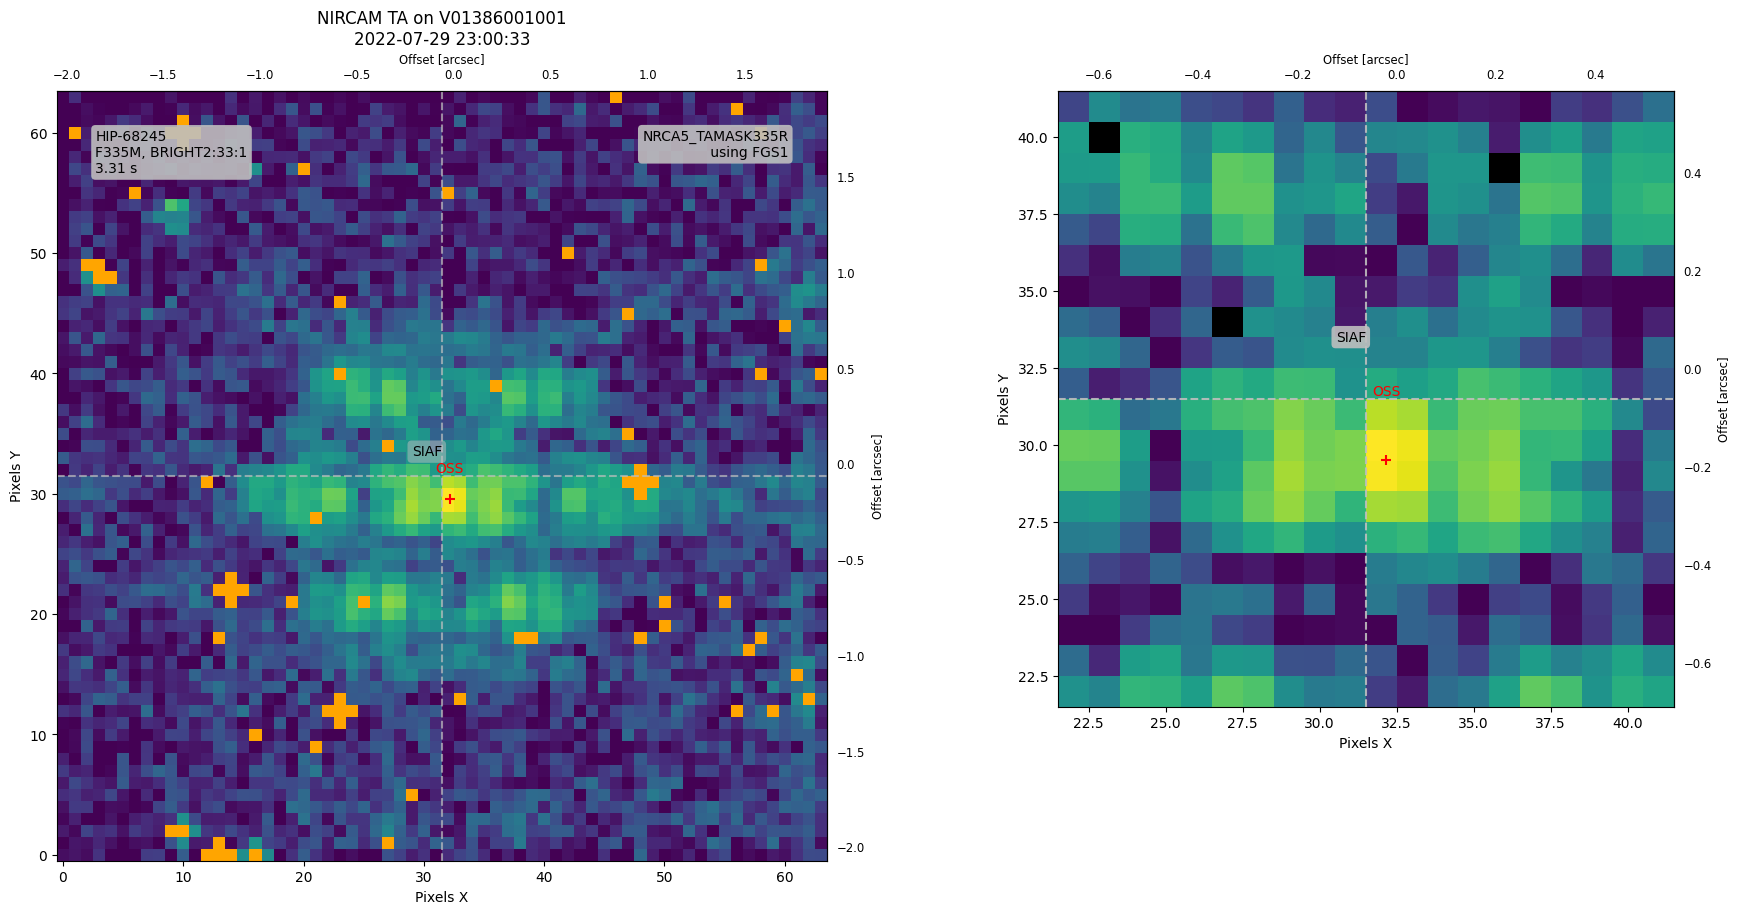

In [14]:
# Update the TA image with the OSS centroid.
fig = ax.get_figure()
for a in (ax, inset_axes):
    a.scatter(oss_cen_sci_pythonic[0], oss_cen_sci_pythonic[1],
              color='red', marker='+', s=50)
    a.text(oss_cen_sci_pythonic[0], oss_cen_sci_pythonic[1] + 2, 'OSS',
           color='red', verticalalignment='bottom',
           horizontalalignment='center')
fig

---

## 5. TA World Coordinate System

Next, we examine the TA World Coordinate System (WCS) to determine where it places the target within the aperture. By comparing this position to the OSS-derived centroid, we can determine the necessary WCS adjustments to align the two points if an offset is present.


In [15]:
# Create a SkyCoord object for the target coordinates (RA, Dec) in ICRS frame.
ta_model = datamodels.open(ta_image_hdul)

targ_coords = astropy.coordinates.SkyCoord(
    ra=ta_model.meta.target.ra,
    dec=ta_model.meta.target.dec,
    frame='icrs',
    unit=u.deg
)

In [16]:
# Convert celestial coordinates (RA, Dec) to pixel coordinates using WCS.
wcs_ta = ta_model.meta.wcs

targ_coords_pix = wcs_ta.world_to_pixel(targ_coords)  # Returns (x, y).
print(f"Target Coordinates based on WCS (x, y): "
      f"({targ_coords_pix[0]:.2f}, {targ_coords_pix[1]:.2f})")

Target Coordinates based on WCS (x, y): (39.02, 31.27)


### 5.1 Plot Target Coordinates from WCS  

Update the TA image plot by overlaying the target coordinate derived from the WCS.

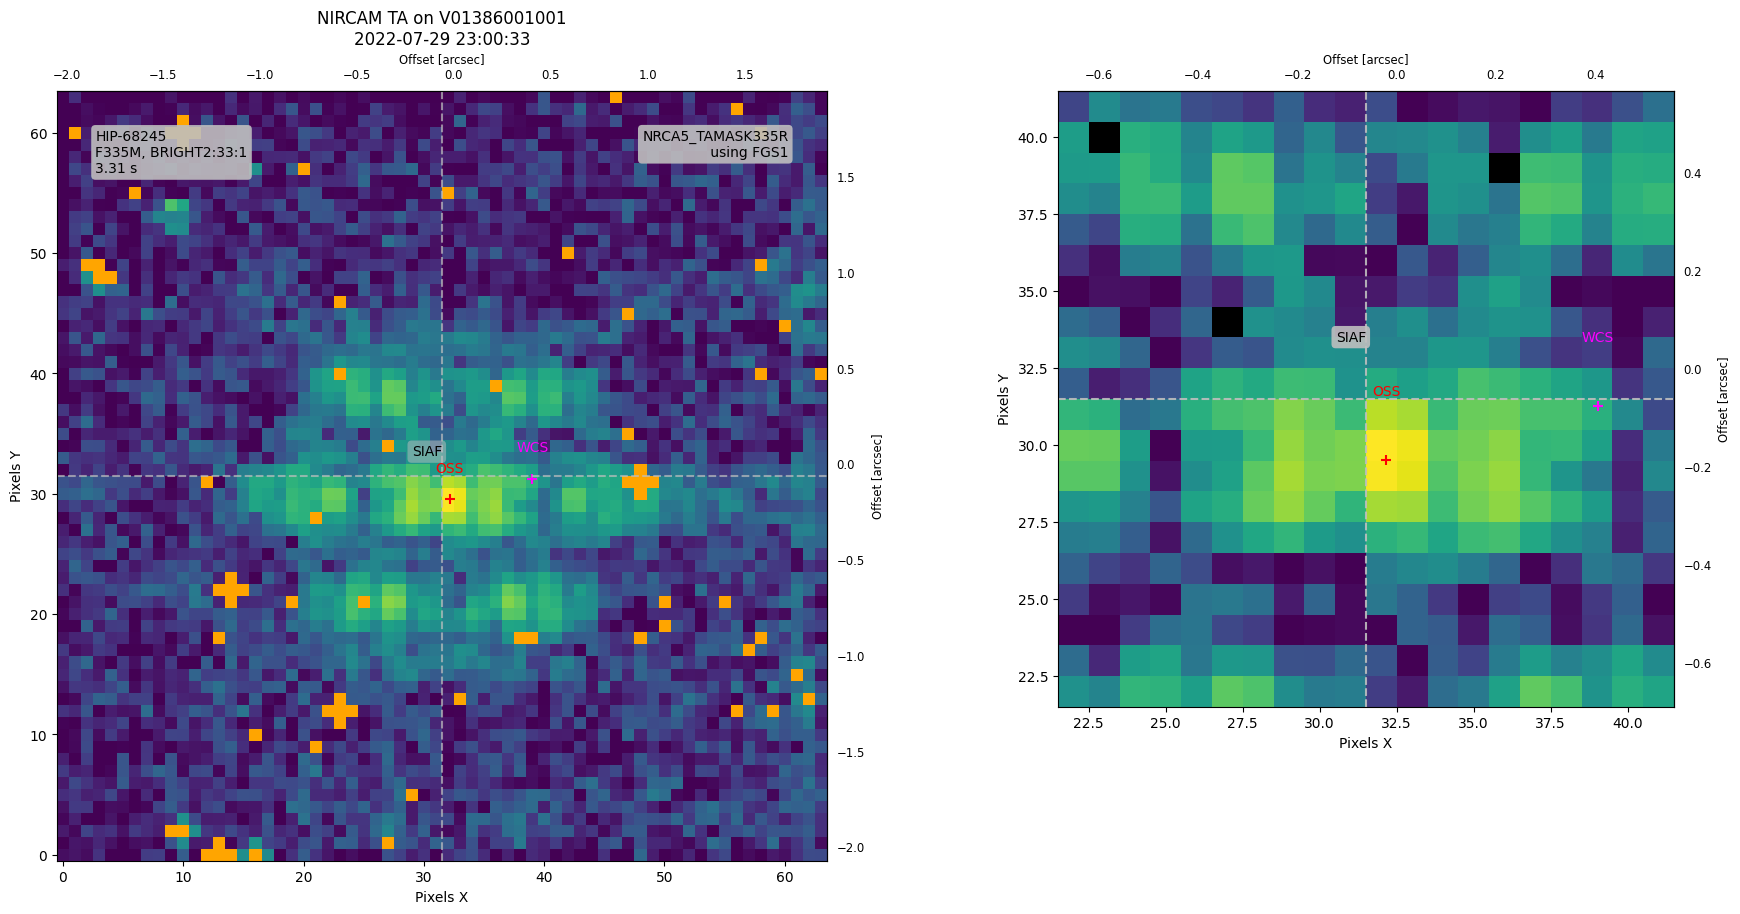

In [17]:
# Update the TA image with the WCS target coordinate.
fig = ax.get_figure()
for a in (ax, inset_axes):
    a.scatter(targ_coords_pix[0], targ_coords_pix[1],
           color='magenta', marker='+', s=50)
    a.text(targ_coords_pix[0], targ_coords_pix[1] + 2, 'WCS',
            color='magenta', verticalalignment='bottom',
            horizontalalignment='center')
fig

---

## 6. Calculate OSS/WCS Offset

In this section, we compute the offset between the OSS-derived centroid and the target coordinate from the TA WCS. 

In [18]:
# --- Compute initial offsets RA/DEC (WCS -> OSS) ---
# Convert the OSS centroid from detector to celestial coordinates (RA, Dec).
ta_cen_coords = wcs_ta.pixel_to_world(*oss_cen_sci_pythonic)
dra = targ_coords.ra - ta_cen_coords.ra
ddec = targ_coords.dec - ta_cen_coords.dec
original_wcs_offset_radec = (dra.to(u.arcsec), ddec.to(u.arcsec))
print(f"Initial TA WCS offset (RA, DEC) = {original_wcs_offset_radec[0]:.3f}, "
      f"{original_wcs_offset_radec[1]:.3f} (WCS - OSS)")

# --- Compute pixel offset (WCS -> OSS) ---
wcs_offset_pix = np.asarray(targ_coords_pix) - oss_cen_sci_pythonic
print(f"Initial TA WCS offset (x, y) [pix] = {wcs_offset_pix[0]:.3f}, "
      f"{wcs_offset_pix[1]:.3f} (WCS - OSS)")

Initial TA WCS offset (RA, DEC) = 0.330 arcsec, 0.364 arcsec (WCS - OSS)
Initial TA WCS offset (x, y) [pix] = 6.865, 1.742 (WCS - OSS)


Now that we’ve computed the offset, we can use `adjust_wcs` to update the TA WCS so that the target coordinates align with the OSS centroid.


In [19]:
# Adjust the WCS from delta RA/DEC.
wcs_ta_adj = adjust_wcs(wcs_ta, *original_wcs_offset_radec)

Let's recompute the target coordinates using the adjusted TA WCS to confirm the adjustment was correct.

In [20]:
# --- Recompute Coordinates using Adjusted TA WCS ---

# Compute the adjusted target centroid in world coordinates.
ta_cen_coords_adj = wcs_ta_adj.pixel_to_world(*oss_cen_sci_pythonic)

# Compute the adjusted target coordinates in pixel space.
targ_coords_pix_adj = wcs_ta_adj.world_to_pixel(targ_coords)
residual_pix = np.asarray(targ_coords_pix_adj) - oss_cen_sci_pythonic
print(f"Residual WCS/OSS offset (x, y) [pix] = "
      f"{residual_pix[0]:.3f}, {residual_pix[1]:.3f}")

# Convert the adjusted pixel coordinates back to world coordinates.
targ_coords_adj = wcs_ta_adj.pixel_to_world(*targ_coords_pix_adj)
dra_residual = targ_coords_adj.ra - ta_cen_coords_adj.ra
ddec_residual = targ_coords_adj.dec - ta_cen_coords_adj.dec
residual_radec = (dra_residual.to(u.arcsec), ddec_residual.to(u.arcsec))
print(f"Residual WCS/OSS offset (RA, DEC) [arcsec] = "
      f"{residual_radec[0]:.6f}, {residual_radec[1]:.6f}")

# Print the final adjusted target coordinates.
print(f"Adjusted Target coordinates (RA, Dec) [deg] = "
      f"{targ_coords_adj.ra.deg:.6f}, {targ_coords_adj.dec.deg:.6f}")
print(f"TA Target coordinates from Adjusted WCS (x, y) [pix] = "
      f"{targ_coords_pix_adj[0]:.3f}, {targ_coords_pix_adj[1]:.3f}")

Residual WCS/OSS offset (x, y) [pix] = 0.012, 0.014
Residual WCS/OSS offset (RA, DEC) [arcsec] = 0.001490 arcsec, 0.000409 arcsec
Adjusted Target coordinates (RA, Dec) [deg] = 209.567586, -42.100881
TA Target coordinates from Adjusted WCS (x, y) [pix] = 32.169, 29.539


Finally, update the TA image plot by overlaying the target coordinate derived from the adjusted WCS.


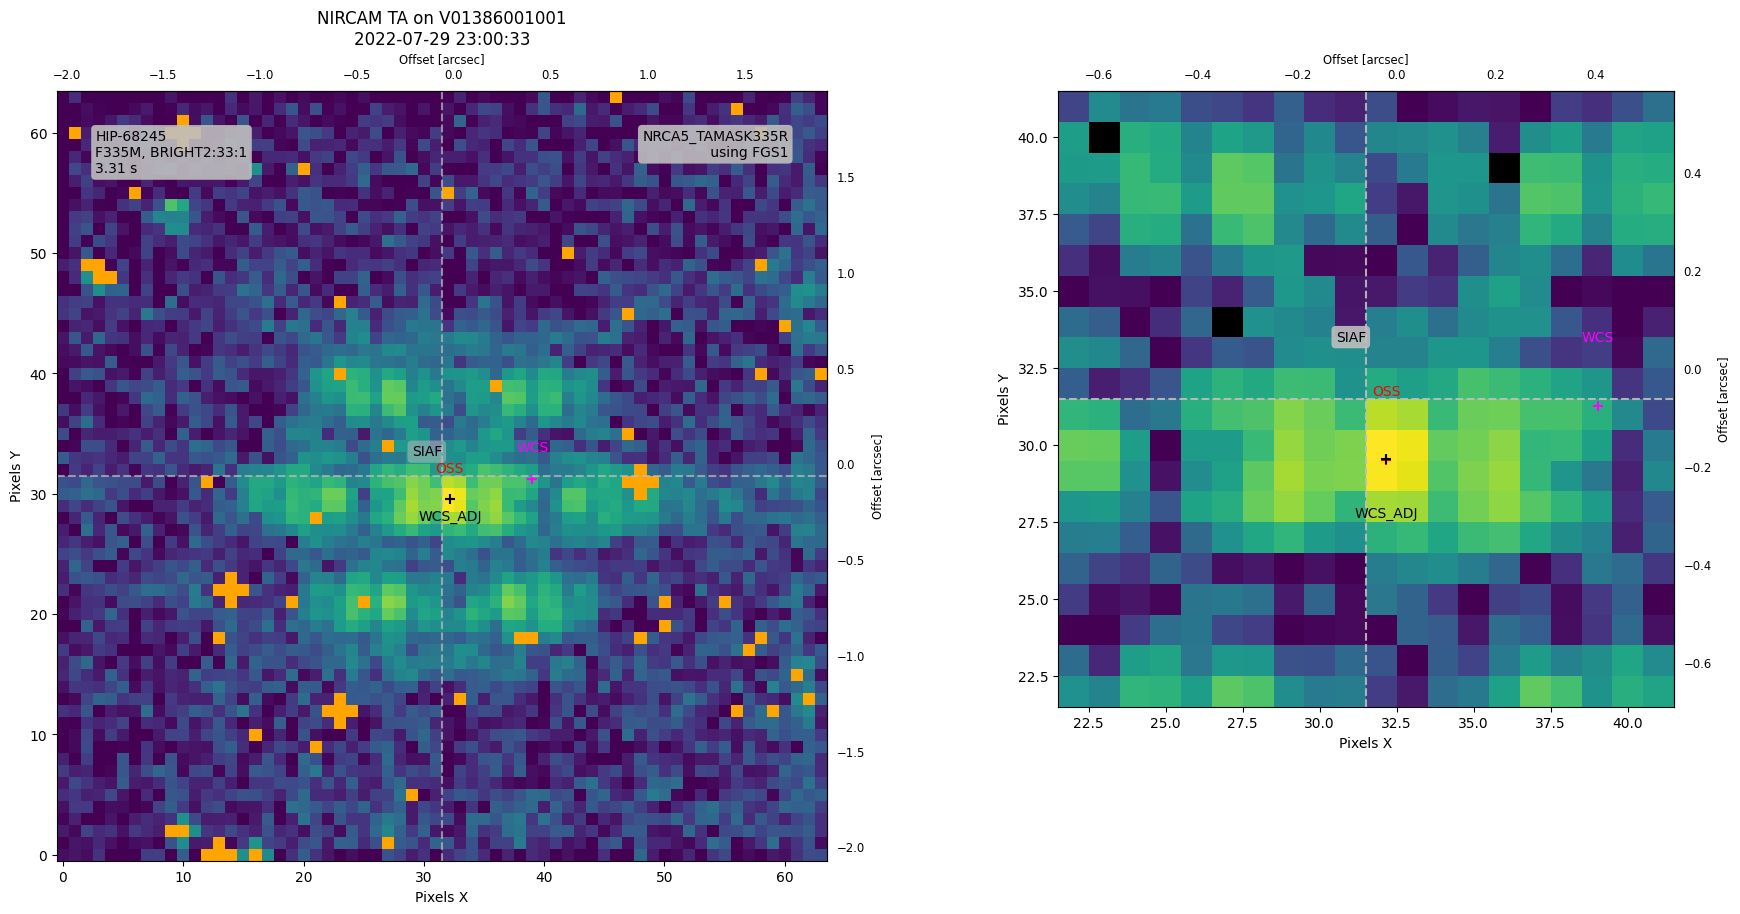

In [21]:
# Update the TA image with the WCS target coordinate.
fig = ax.get_figure()
for a in (ax, inset_axes):
    a.scatter(targ_coords_pix_adj[0], targ_coords_pix_adj[1],
           color='black', marker='+', s=50)
    a.text(targ_coords_pix_adj[0], targ_coords_pix_adj[1] - 2, 'WCS_ADJ',
            color='black', verticalalignment='bottom',
            horizontalalignment='center')
fig

---

## 7. Conclusion

All the steps described in the previous sections are performed automatically in the `ta_analysis` routine in `target_acq_tools.py`—provided you supply a FITS file with the necessary header information (instrument name and visit ID). The `ta_analysis` routine will apply the TA WCS adjustment to the science data and return the adjusted target coordinates in pixels (within the science aperture).

[spaceKLIP.target_acq_tools:INFO] --> TA Analysis: Target coordinates (RA, Dec) [deg]: (209.567586, -42.100881)
[spaceKLIP.target_acq_tools:INFO]                  Target coordinates (x, y) [pix]: (39.022, 31.266) (sci frame in NRCA5_TAMASK335R, 0-based)
[spaceKLIP.target_acq_tools:INFO]                  Target coordinates from OSS centroid (x, y) [pix]: (32.156300, 29.524310) (sci frame in NRCA5_TAMASK335R, 0-based)
[spaceKLIP.target_acq_tools:INFO]                  Target coordinates from OSS centroid (RA, Dec) [deg]: (209.567494, -42.100982)
[spaceKLIP.target_acq_tools:INFO]                  Calculating offsets ...
[spaceKLIP.target_acq_tools:INFO]                  Target coordinates WCS - OSS offset (RA, Dec) [deg]: (0.330 arcsec, 0.364 arcsec)
[spaceKLIP.target_acq_tools:INFO]                  Target coordinates WCS - OSS offset (x, y) [pix]: (6.865, 1.742)
[spaceKLIP.target_acq_tools:INFO]                  Adjusting TA WCS based on offset ...
[spaceKLIP.target_acq_tools:INFO]     

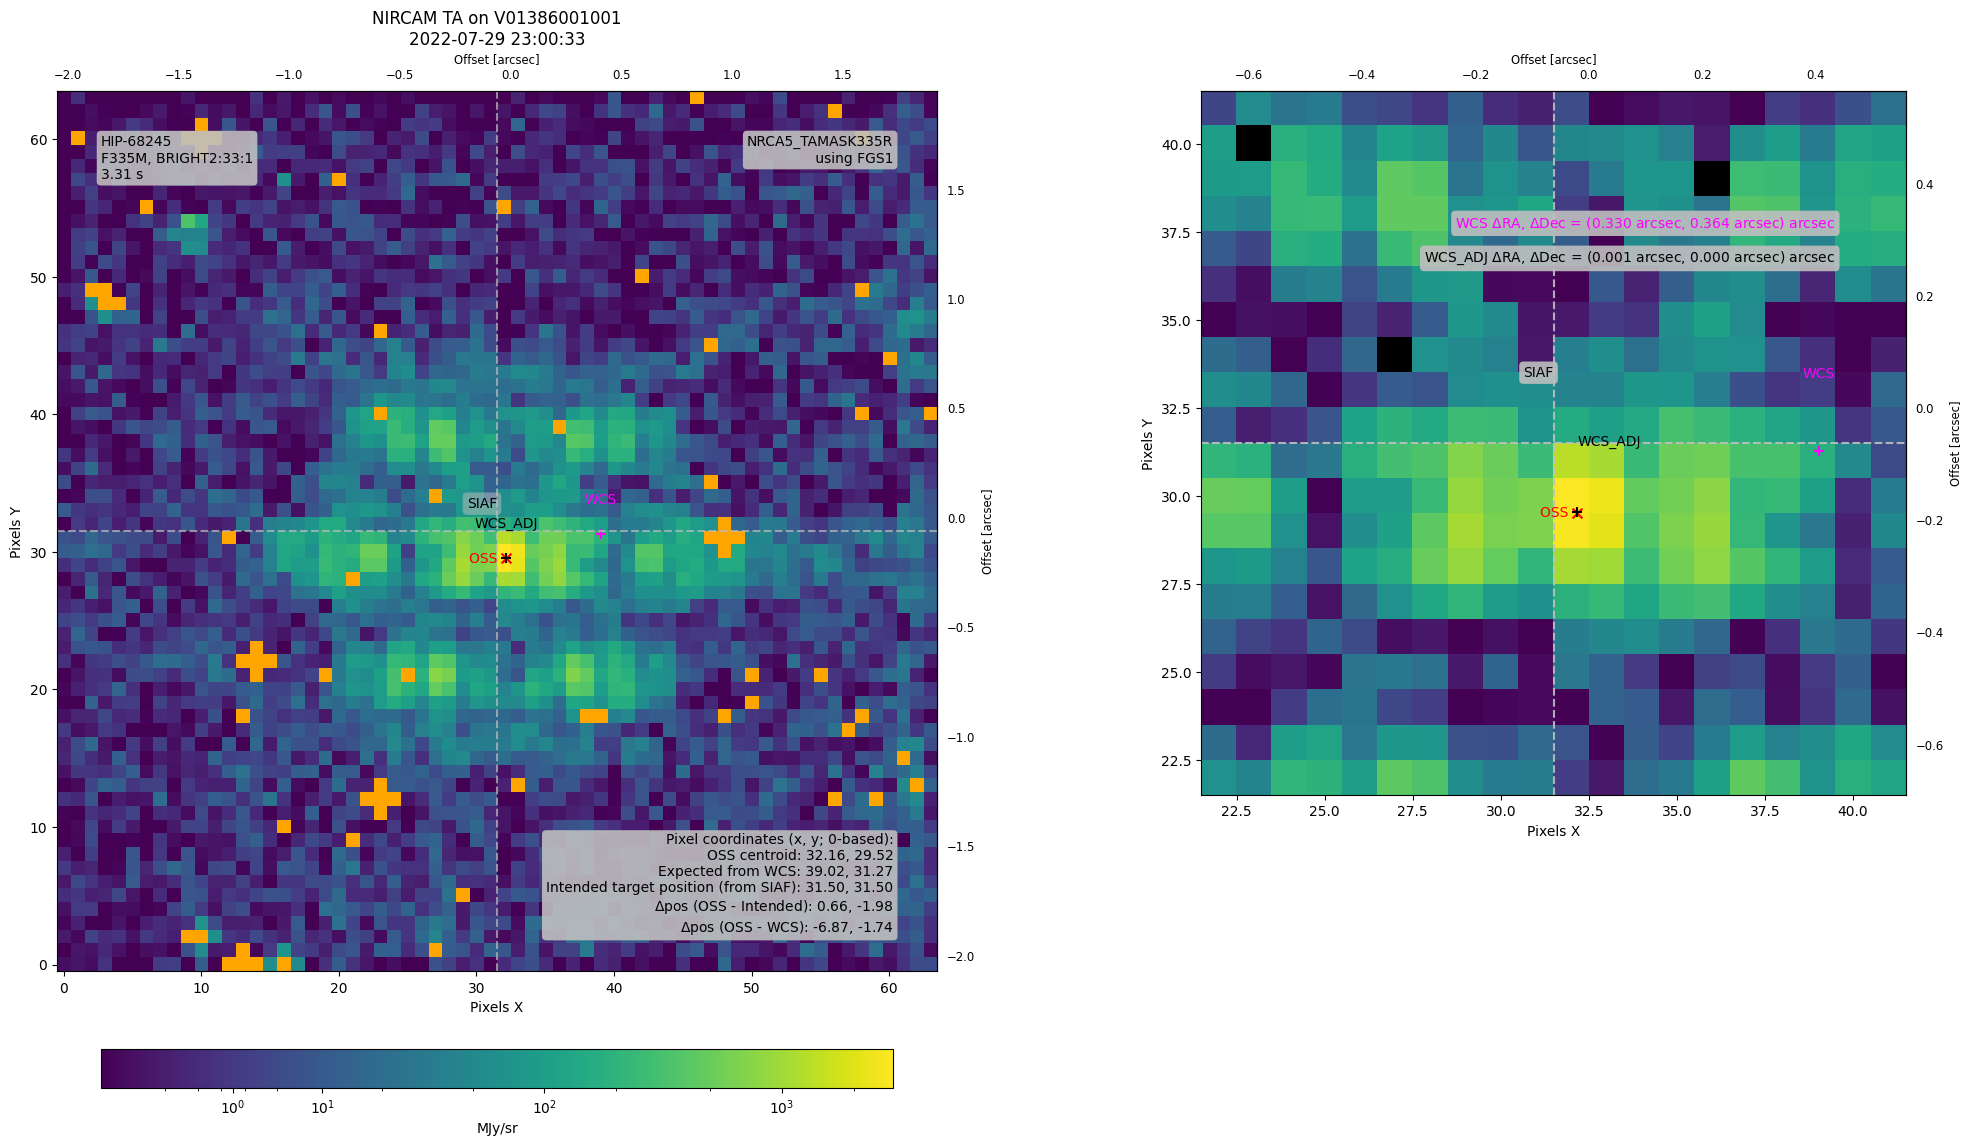

In [22]:
targ_coords_pix_adj_sci = target_acq_tools.ta_analysis(cal_product,
                                                       verbose=True,
                                                       plot=True)

As a last check, let's plot the adjusted target coordinates in the SCI frame.

The SCI aperture is NRCA5_MASK335R


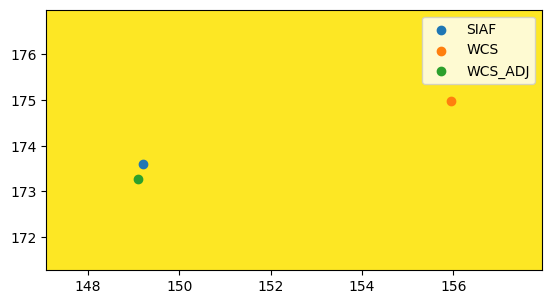

In [23]:
cal = datamodels.open(cal_product)
cal_data = cal.data[0]

targ_coords_pix_sci = cal.meta.wcs.world_to_pixel(targ_coords)  # Returns (x, y).

sci_aperture = siaf.apertures[cal.meta.aperture.name]
xref_sci, yref_sci = sci_aperture.XSciRef - 1, sci_aperture.YSciRef - 1  # 1-indexed
# This should match the label in the plots above.
print(f"The SCI aperture is {sci_aperture.AperName}")

plt.imshow(cal_data, vmin=np.nanpercentile(cal_data, 5),
           vmax=np.nanpercentile(cal_data, 80), origin='lower')
plt.scatter(xref_sci, yref_sci, label='SIAF')
plt.scatter(*targ_coords_pix_sci, label='WCS')
plt.scatter(targ_coords_pix_adj_sci[0], targ_coords_pix_adj_sci[1], label='WCS_ADJ')

# Collect all scatter points into arrays
all_x = [xref_sci, targ_coords_pix_sci[0], targ_coords_pix_adj_sci[0]]
all_y = [yref_sci, targ_coords_pix_sci[1], targ_coords_pix_adj_sci[1]]

# Automatically set limits with padding
padding = 2 # Add some padding to the limits
plt.xlim(min(all_x) - padding, max(all_x) + padding)
plt.ylim(min(all_y) - padding, max(all_y) + padding)
plt.legend()

We can use the option in the `calculate_centers` function (part of SpaceKLIP's `ImageTools` class) to refine the PSF center before PSF subtraction.











